In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# Function to generate image pairs
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)

In [ ]:
# Get the data directory paths
faces = 'olivetti_faces.npy'
faces_targets = 'olivetti_faces_target.npy'

In [ ]:
# Load the images and labels
face_images = np.load(faces)
face_labels = np.load(faces_targets)

In [ ]:
target_shape = face_images[0].shape

In [ ]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

In [ ]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])


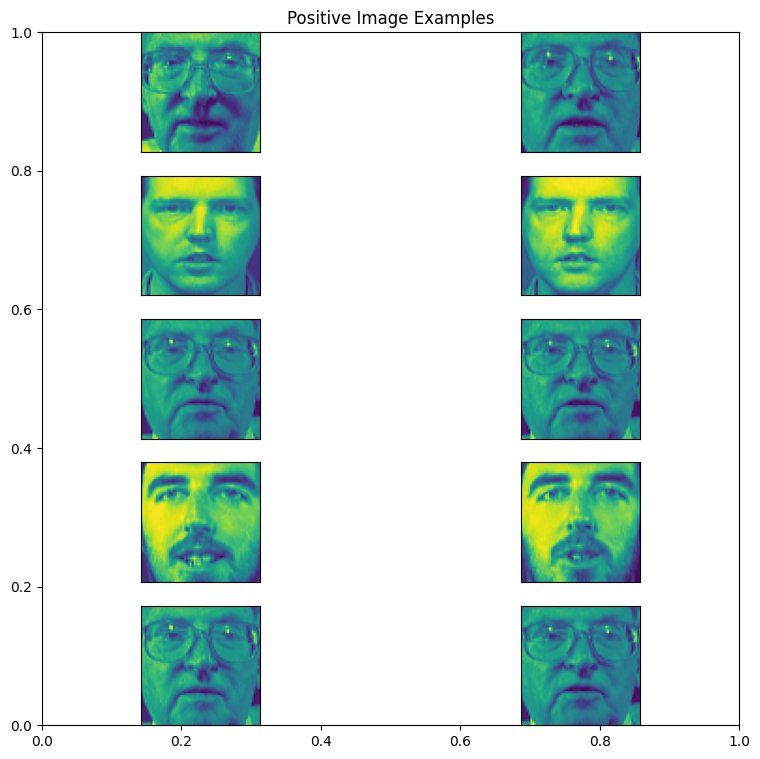

In [ ]:
# Visualize Positive Images
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

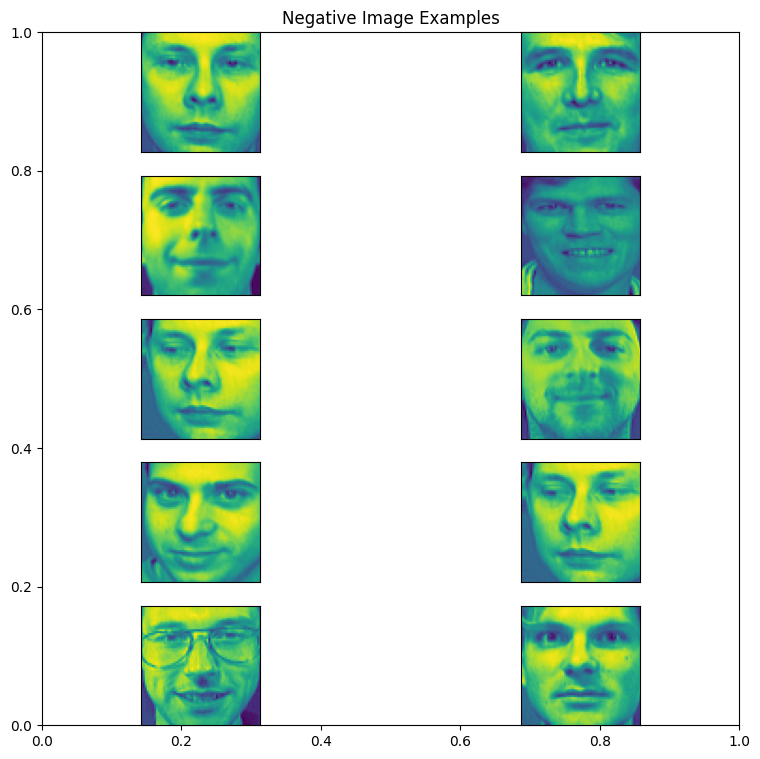

In [ ]:
# Visualize Negative Images
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

In [ ]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
# Distance Layer
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [ ]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

In [ ]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 [==============================] - 14s 298ms/step - loss: 0.6772 - accuracy: 0.4906 - val_loss: 0.6182 - val_accuracy: 0.5688
Epoch 2/150
10/10 [==============================] - 1s 116ms/step - loss: 0.6454 - accuracy: 0.4906 - val_loss: 0.6067 - val_accuracy: 0.5750
Epoch 3/150
10/10 [==============================] - 1s 115ms/step - loss: 0.6418 - accuracy: 0.4906 - val_loss: 0.6147 - val_accuracy: 0.5750
Epoch 4/150
10/10 [==============================] - 1s 116ms/step - loss: 0.6428 - accuracy: 0.4906 - val_loss: 0.6119 - val_accuracy: 0.5875
Epoch 5/150
10/10 [==============================] - 1s 115ms/step - loss: 0.6377 - accuracy: 0.4906 - val_loss: 0.6516 - val_accuracy: 0.5688
Epoch 6/150
10/10 [==============================] - 1s 116ms/step - loss: 0.6414 - accuracy: 0.5063 - val_loss: 0.6403 - val_accuracy: 0.5875
Epoch 7/150
10/10 [==============================] - 1s 119ms/step - loss: 0.6648 - accuracy: 0.5656 - val_loss: 0.6803 - val_accuracy: 0.662

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
siamese_model.save("/drive/MyDrive/BioMetrie/model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
target_shape

(64, 64)

In [ ]:
im = cv2.imread("personne.png")
im = cv2.resize(im, (64, 64))

# Convert the resized image to grayscale
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

im2.shape

im2 = cv2.imread("lastJardinImage.png")
im2 = cv2.resize(im2, (64, 64))

# Convert the resized image to grayscale
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

im2.shape

machiKifKif = []
machiKifKif.append([im,im2])
machiKifKif = np.array(machiKifKif)
machiKifKif.shape

((1, 1, 64, 64), (1, 1, 64, 64))

In [ ]:
images_dataset.shape

(800, 2, 64, 64)

In [ ]:
score = siamese_model.predict([machiKifKif[:, 0, :], machiKifKif[:, 1, :]])

1/1 [==============================] - 0s 19ms/step


In [ ]:
score

array([[0.5193978]], dtype=float32)

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2024-01-27 21:23:42--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M   639KB/s    in 98s     

2024-01-27 21:25:20 (1.75 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
!tar -xf lfw.tgz